# ITU-T G.227 実数 FIR フィルタ

まず、ITU-T G.227 https://www.itu.int/rec/T-REC-G.227-198811-I/en

記載の伝達関数を周波数特性としてグラフ化。普通のフィルタのグラフと違ってyはゲインではなくロスなので注意


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import json

def g227(niq, size):
    f = np.linspace(0, niq, size)
    p = 1j * f / 1000
    numerator = 18400 + 91238*p**2 + 11638*p**4 + p*(67280 + 54050*p**2)
    denominator = 400 + 4001*p**2 + p**4 + p*(36040 + 130*p**2)
    loss = np.abs(numerator / denominator)
    dB = 20 * np.log10(loss)
    # adjust gain
    dB -= np.min(dB)
    loss = np.power(10, dB / 20)
    return f, loss

0.0


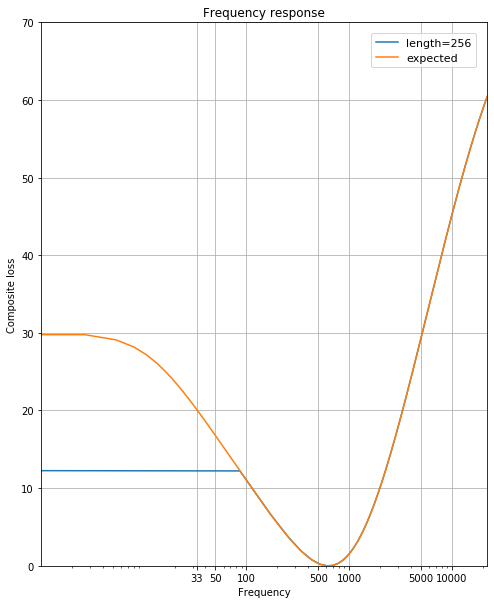

In [2]:
sr = 44100
firlen = 513
xticks = [33, 50, 100, 500, 1000, 5000, 10000]

f_m, loss_m = g227(sr/2, 2**13)
f, loss = g227(sr/2, int(firlen/2))

print(np.min(20 * np.log10(loss)))
plt.figure(figsize=(8,10))
plt.title("Frequency response")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Composite loss')
plt.xlabel('Frequency')
plt.ylim((0, 70))
#plt.xlim((33, 10000))
plt.xlim((1, sr/2))
plt.xticks(xticks, xticks)
plt.plot(f, 20 * np.log10(loss), label="length=%d" % int(firlen/2))
plt.plot(f_m, 20 * np.log10(loss_m), label="expected")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

plt.show()

# 要求の周波数特性をつくる

実数フィルタにしたいので左右対称にする

512


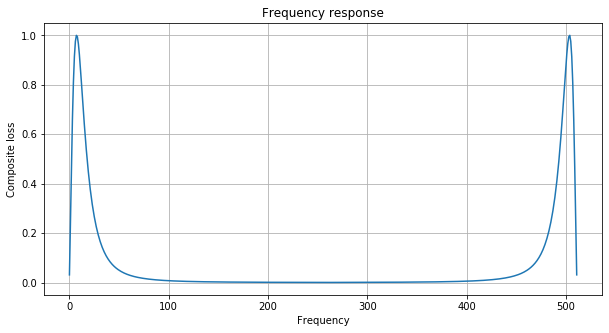

In [3]:
gain = 1.0/loss

gain = list(gain) + list(gain[::-1])
print(len(gain))
plt.figure(figsize=(10,5))
plt.title("Frequency response")
plt.grid(True)
plt.ylabel('Composite loss')
plt.xlabel('Frequency')
plt.plot(gain)


# FIR

IFFT して有限インパルス応答 (FIR) を得る。

512


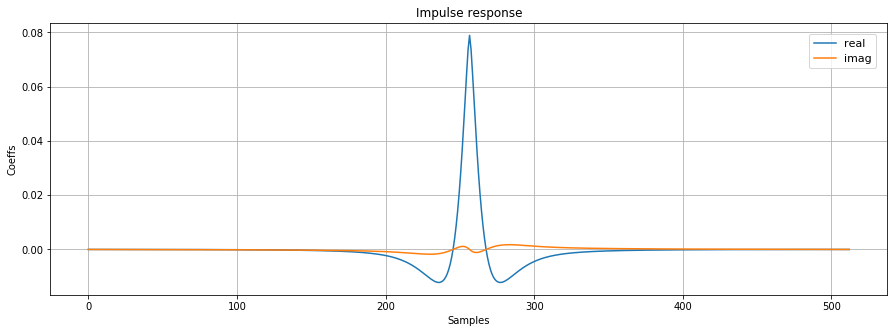

In [4]:
fir = np.fft.fftshift(np.fft.ifft(gain))
print(len(fir))
x = np.linspace(0, len(fir), len(fir))
plt.figure(figsize=(15,5))
plt.title("Impulse response")
plt.grid(True)
plt.ylabel("Coeffs")
plt.xlabel("Samples")
plt.plot(x, np.real(fir), label="real")
plt.plot(x, np.imag(fir), label="imag")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)
plt.show()
fir = np.real(fir)

# FIR の周波数特性

求めた FIR の周波数特性を評価する。freqz を使う。


12.674339983109126
Max Error 6.3715686374777505 dB at 43.06640625 Hz
MSE 0.1451089475236209 dB


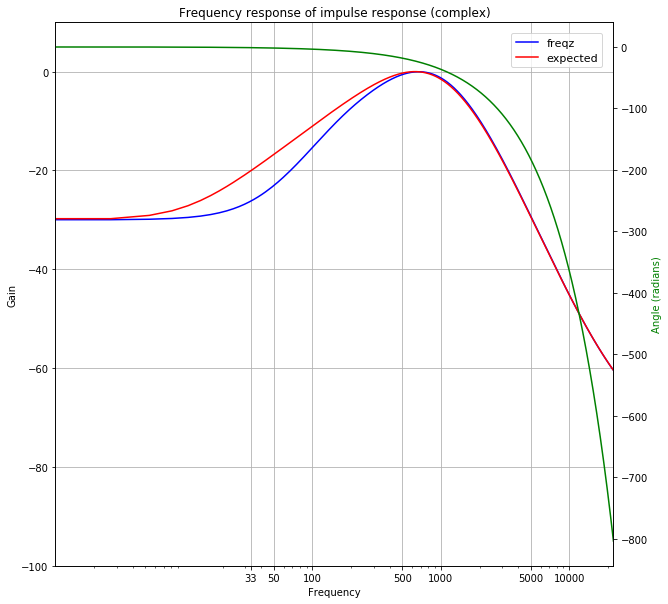

In [5]:
w, h = signal.freqz(fir, worN=2**13)
x = w * sr * 1.0 / (2 * np.pi)
plt.figure(figsize=(10,10))
plt.title("Frequency response of impulse response (complex)")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Gain')
plt.xlabel('Frequency')
plt.xlim((1, sr/2))
plt.ylim((-100, 10))
plt.xticks(xticks, xticks)

freqz_dB = 20 * np.log10(abs(h))
expected_dB = -20 * np.log10(loss_m)
plt.plot(x, 20 * np.log10(np.abs(h)), 'b', label="freqz")
plt.plot(f_m, -20 * np.log10(loss_m), 'r', label="expected")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)
print(len(h) / np.sum(np.abs(h)))

error = np.abs(freqz_dB- expected_dB)
print('Max Error', np.max(error), 'dB', 'at', x[np.argmax(error)], 'Hz')
print('MSE',  20*np.log10(np.sqrt(np.mean(np.power(10, error / 20)**2))), 'dB')

ax2 = plt.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(x, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')

plt.show()

# JSON

In [6]:
print(json.dumps(list(map(lambda x: x.real, fir))))

[0.0, -4.959127400394614e-09, -1.984185008657713e-08, -4.465219102106621e-08, -7.942086416995453e-08, -1.2414527018542176e-07, -1.7889755019734332e-07, -2.4365250187244336e-07, -3.1853981026855327e-07, -4.034956754073518e-07, -4.987235258865907e-07, -6.04104936302943e-07, -7.199333812793213e-07, -8.460197299968095e-07, -9.82763928783579e-07, -1.1298899900745799e-06, -1.2879209015173587e-06, -1.4564775768222127e-06, -1.6362227797123846e-06, -1.8266579731376908e-06, -2.0286026184684197e-06, -2.241422246173838e-06, -2.4661101459249463e-06, -2.701879284430775e-06, -2.949914142313416e-06, -3.209258321477601e-06, -3.4813051117878885e-06, -3.7649117590110234e-06, -4.061698260547121e-06, -4.370318303494741e-06, -4.692636796376631e-06, -5.027086432512519e-06, -5.3757955666084226e-06, -5.73695820863928e-06, -6.11298505329063e-06, -6.501813460757424e-06, -6.906155746604949e-06, -7.323674354882317e-06, -7.757402919627947e-06, -8.204710378781777e-06, -8.668971830077653e-06, -9.147243767364515e-06, 